In [1]:
# Manish Aradwad / 19494

from scipy import optimize
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
!wget https://ece.iisc.ac.in/~rajeshs/E0259/04_cricket_1999to2011.csv
data = pd.read_csv('./04_cricket_1999to2011.csv')
data = data[data['Innings']==1]

# Data Preprocessing required for Total.Runs column
for i in tqdm(range(len(data))):
    if data.iloc[i]['Over'] == 1:
        data.iloc[i]['Total.Runs'] = data.iloc[i]['Runs']
    else:
        data.iloc[i]['Total.Runs'] = data.iloc[i]['Runs'] + data.iloc[i-1]['Total.Runs']

--2022-08-20 16:29:37--  https://ece.iisc.ac.in/~rajeshs/E0259/04_cricket_1999to2011.csv
Resolving ece.iisc.ac.in (ece.iisc.ac.in)... 13.71.53.212
Connecting to ece.iisc.ac.in (ece.iisc.ac.in)|13.71.53.212|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22421891 (21M) [text/csv]
Saving to: ‘04_cricket_1999to2011.csv’

04_cricket_1999to20 100%[===================>]  21.38M  7.48MB/s    in 2.9s    

2022-08-20 16:29:41 (7.48 MB/s) - ‘04_cricket_1999to2011.csv’ saved [22421891/22421891]



100%|██████████| 67794/67794 [00:58<00:00, 1167.43it/s]


In [3]:
data = data[['Over', 'Total.Runs', 'Innings.Total.Runs', 'Wickets.in.Hand']] # Getting the required columns
data

,Over,Total.Runs,Innings.Total.Runs,Wickets.in.Hand
0,1,4,204,10
1,2,6,204,10
2,3,9,204,10
3,4,20,204,10
4,5,37,204,10
...,...,...,...,...
126719,46,244,267,6
126720,47,250,267,5
126721,48,258,267,5
126722,49,258,267,5


In [23]:
def DLS():
    x0 = 250 * np.ones(11)
    x0[10] = 0.1
    result = optimize.minimize(fun = error_func, x0 = x0, args = (data))
    Z = result.x[:10]
    L = result.x[10]
    errors = np.zeros(10)

    for w in range(1,11):
        temp = data[data['Wickets.in.Hand'] == w]
        overs_rem = 50 - temp['Over']
        runs = temp['Innings.Total.Runs'] - temp['Total.Runs']
        pred_runs = Z[w-1] * np.subtract(1, np.exp(np.multiply(-L/Z[w-1], overs_rem)))
        errors[w-1] = np.sqrt(np.sum(np.square(np.subtract(runs, pred_runs))) / len(data))

    return Z, L, errors

def error_func(Z, data):
    L=Z[10]
    error=0

    for w in range(1,11):
        temp = data[data['Wickets.in.Hand'] == w]
        overs_rem = 50 - temp['Over']
        runs = temp['Innings.Total.Runs'] - temp['Total.Runs']
        pred_runs = Z[w-1] * np.subtract(1, np.exp(np.multiply(-L/Z[w-1], overs_rem)))
        error += np.sqrt(np.sum(np.square(np.subtract(runs, pred_runs))) / len(data))
    
    return error

def func(Z, L, w, u):
  return Z[w-1] * (1 - np.exp(-L*u/Z[w-1]))

def display(Z, L):
    for w in range(1, 11):
        x = range(0, 51)
        y = np.array([func(Z, L, w, u) for u in range(0, 51)])

        plt.plot(x, y, label=str(w))
        plt.text(x[-5],y[-5],w)
        plt.xlabel("Overs Remaining")
        plt.ylabel("Runs")
    
    plt.show()

100%|██████████| 10/10 [00:00<00:00, 390.59it/s]


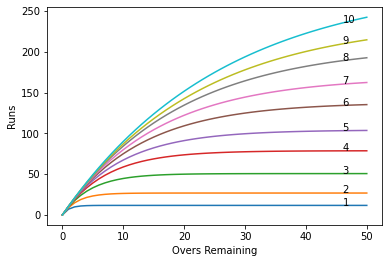

In [24]:
Z0, L, errors = DLS()
display(Z0, L)

In [29]:
print('Z0\t\tL\t\terrors\n')
for i in range(10):
    print(f'{Z0[i]:.2f}\t\t{L:.5f}\t{errors[i]:.2f}')

Z0		L		errors

11.67		10.82669	1.44
26.83		10.82669	2.64
50.68		10.82669	4.52
78.72		10.82669	6.54
104.16		10.82669	9.13
138.01		10.82669	11.72
169.31		10.82669	14.17
208.20		10.82669	17.25
239.85		10.82669	19.42
285.13		10.82669	19.53


In [19]:
# Getting the score using DLS for given resources remaining
wkt = 7
overs = 25
print(f"Target when {wkt} wickets in hand and {overs} overs remaining are: {int(np.ceil(func(Z0, L, wkt, overs)))}")

Target when 7 wickets in hand and 25 overs remaining are: 136
